In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np

basics = pd.read_csv("title.basics.tsv", sep='\t', na_values='\\N', low_memory=False)
ratings = pd.read_csv("title.ratings.tsv", sep='\t', na_values='\\N')

#Filters for just movies
movies = basics[basics['titleType'] == 'movie'].copy()
print(f"Movies after filtering: {movies.shape}")

#Converts columns into numeric
movies['startYear'] = pd.to_numeric(movies['startYear'], errors='coerce')
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')
ratings['averageRating'] = pd.to_numeric(ratings['averageRating'], errors='coerce')
ratings['numVotes'] = pd.to_numeric(ratings['numVotes'], errors='coerce')

#Merges basics and ratings
df = pd.merge(movies, ratings, on='tconst', how='inner')

#Drops rows with average rating
df = df.dropna(subset=['averageRating'])

#Creates features based on years
df['startYear_filled'] = df['startYear'].fillna(df['startYear'].median())
df['movie_age'] = 2024 - df['startYear_filled']
df['is_recent'] = (df['startYear_filled'] >= 2010).astype(int)
df['decade'] = (df['startYear_filled'] // 10) * 10

#Creates attributes about runtime
df['runtimeMinutes_filled'] = df['runtimeMinutes'].fillna(df['runtimeMinutes'].median())
df['is_short_film'] = (df['runtimeMinutes_filled'] < 90).astype(int)
df['is_long_film'] = (df['runtimeMinutes_filled'] > 150).astype(int)

#Creates attributes about votes
df['numVotes_log'] = np.log1p(df['numVotes'])
df['high_vote_count'] = (df['numVotes'] > df['numVotes'].quantile(0.75)).astype(int)

#Handles multiple genres
df['genres_filled'] = df['genres'].fillna('Unknown')

#Gets all unique Genres
all_genres = set()
for genres_str in df['genres_filled']:
    if pd.notna(genres_str) and genres_str != 'Unknown':
        genres = genres_str.split(',')
        all_genres.update(genres)

#Creates dummies for genres
for genre in sorted(all_genres):
    df[f'genre_{genre}'] = df['genres_filled'].str.contains(genre, na=False).astype(int)

#Creates attributes for titles
df['title_length'] = df['primaryTitle'].str.len()
df['has_article'] = df['primaryTitle'].str.startswith(('The ', 'A ', 'An ')).astype(int)

#Selects features for modeling
feature_cols = [
    'startYear_filled', 'movie_age', 'is_recent',
    'runtimeMinutes_filled', 'is_short_film', 'is_long_film',
    'numVotes_log', 'high_vote_count',
    'title_length', 'has_article'
]

#Adds genre columns
genre_cols = [col for col in df.columns if col.startswith('genre_')]
feature_cols.extend(genre_cols)

#Adds the decade as a feature
decade_dummies = pd.get_dummies(df['decade'], prefix='decade')
df = pd.concat([df, decade_dummies], axis=1)
decade_cols = decade_dummies.columns.tolist()
feature_cols.extend(decade_cols)

#Prepares the features and the target
X = df[feature_cols]
y = df['averageRating']

#Checks if there are any values missing
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)


#Splits the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Trains the model
print("\nStarting model training")
model = LinearRegression()
model.fit(X_train, y_train)

#Makes predictions
y_pred = model.predict(X_test)

#Evaluates the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f} rating points")
print(f"Root Mean Square Error: {rmse:.4f} rating points")

#Shows the importance of features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(feature_importance.head(15)[['feature', 'coefficient']].to_string(index=False))

#Shows example predictions
print(f"\nSample Predictions vs Actual:")
sample_idx = np.random.choice(len(X_test), 10, replace=False)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[sample_idx].values,
    'Predicted': y_pred[sample_idx],
    'Difference': y_test.iloc[sample_idx].values - y_pred[sample_idx]
})
comparison['Predicted'] = comparison['Predicted'].round(2)
comparison['Difference'] = comparison['Difference'].round(2)
print(comparison.to_string(index=False))

#Stats about the dataset
print(f"\nDataset Statistics:")
print(f"Average rating: {y.mean():.2f}")
print(f"Rating std dev: {y.std():.2f}")
print(f"Rating range: {y.min():.1f} - {y.max():.1f}")

#Range analysis
valid_years = df['startYear_filled'].dropna()
print(f"\nYear Range Analysis:")
print(f"Earliest movie year: {int(valid_years.min())}")
print(f"Latest movie year: {int(valid_years.max())}")
print(f"Total years covered: {int(valid_years.max() - valid_years.min() + 1)} years")
print(f"Year span: {int(valid_years.min())}-{int(valid_years.max())}")

#Prints movies per decade
decade_counts = df['decade'].value_counts().sort_index()
print(f"\nMovies per decade:")
for decade, count in decade_counts.items():
    if pd.notna(decade):
        print(f"  {int(decade)}s: {count:,} movies")

print(f"\nMost common genres:")
top_genres = feature_importance[feature_importance['feature'].str.startswith('genre_')].head(5)
for _, row in top_genres.iterrows():
    genre_name = row['feature'].replace('genre_', '')
    genre_count = df[row['feature']].sum()
    print(f"  {genre_name}: {genre_count} movies")

Loading IMDb datasets...
Basics dataset shape: (1048575, 9)
Ratings dataset shape: (1594323, 3)
Movies after filtering: (228953, 9)
After merging with ratings: (152846, 11)
After dropping rows without ratings: (152846, 11)

Features selected: 51
Sample size: 152846
Final missing values: 0

Training set: (122276, 51)
Test set: (30570, 51)

Training Linear Regression model...

Model Performance:
R² Score: 0.1737
Mean Absolute Error: 0.8424 rating points
Root Mean Square Error: 1.0938 rating points

Top 15 Most Important Features:
          feature  coefficient
    decade_1890.0    -2.878618
    decade_1900.0    -1.631175
genre_Documentary     1.342229
 genre_Reality-TV     0.916763
     genre_Horror    -0.782893
    decade_1920.0     0.651125
    decade_1940.0     0.647440
    decade_1930.0     0.639185
    decade_1950.0     0.562046
  genre_Animation     0.549300
     genre_Sci-Fi    -0.491658
    decade_1960.0     0.458391
    decade_1910.0     0.435048
     is_long_film     0.321981
 

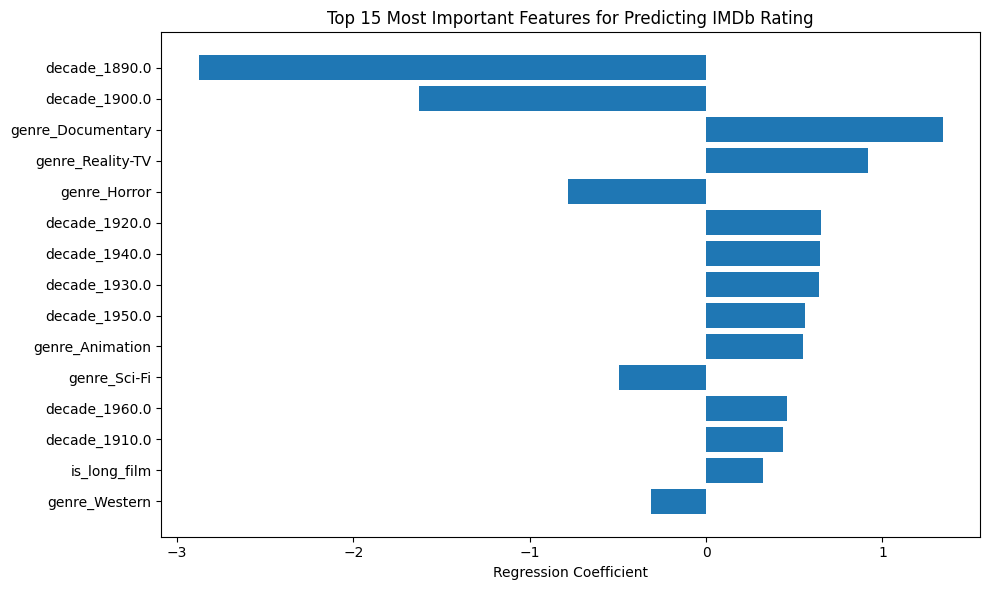

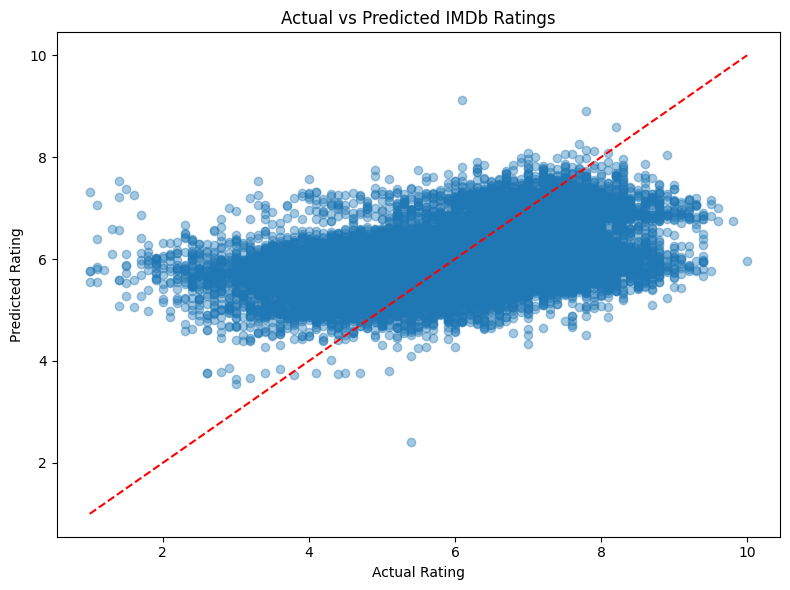

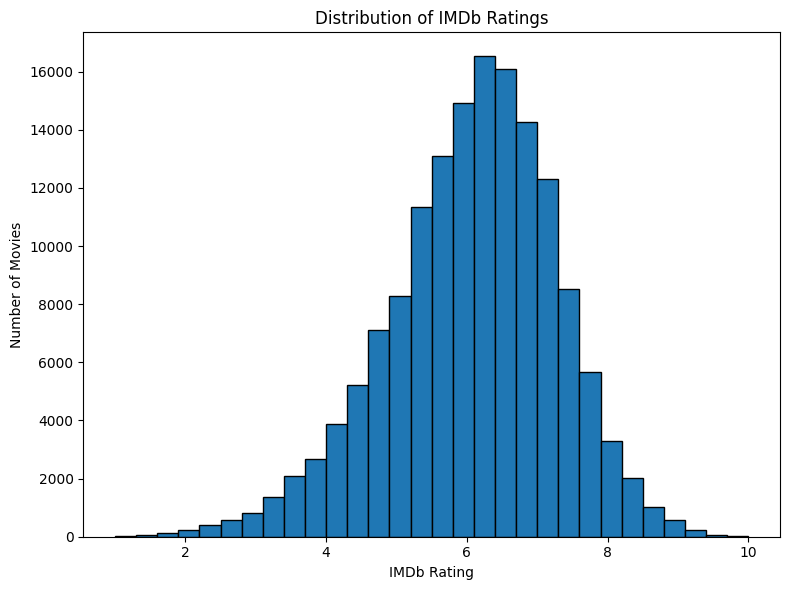

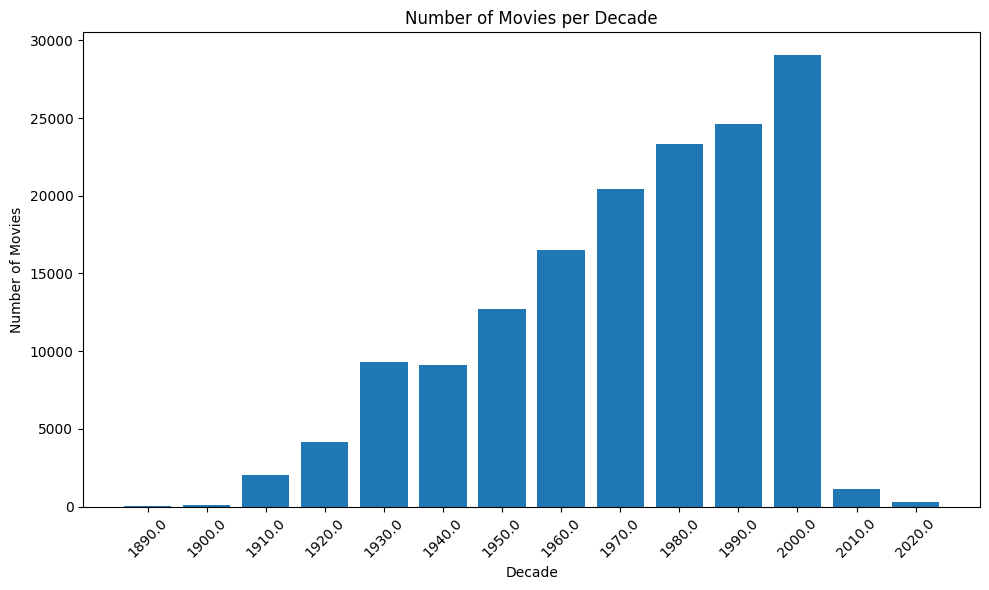

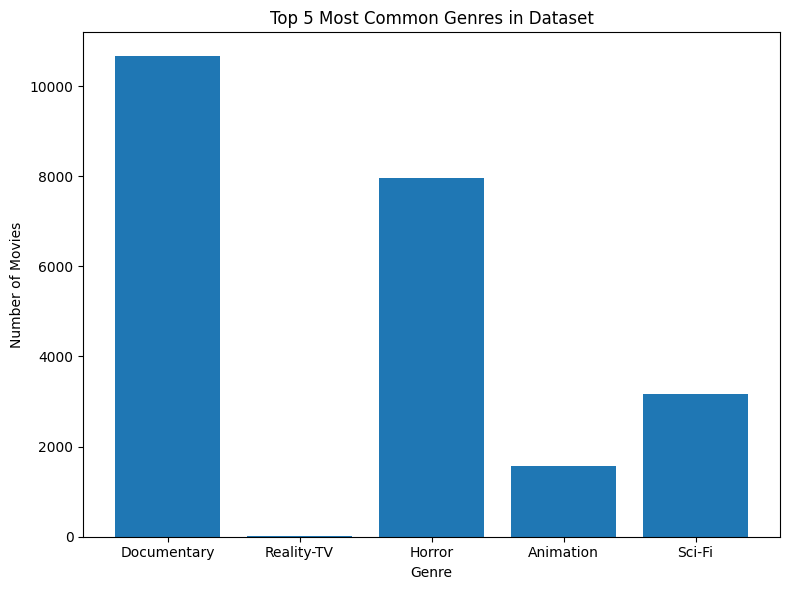

In [ ]:
import matplotlib.pyplot as plt

#Top 15 Most Important Features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.gca().invert_yaxis()
plt.title('Top 15 Most Important Features for Predicting IMDb Rating')
plt.xlabel('Regression Coefficient')
plt.tight_layout()
plt.show()

#Predicted vs Actual Ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted IMDb Ratings')
plt.tight_layout()
plt.show()

#Distribution of IMDb Ratings
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, edgecolor='black')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

#Movies per Decade
plt.figure(figsize=(10, 6))
decade_counts = df['decade'].value_counts().sort_index()
plt.bar(decade_counts.index.astype(str), decade_counts.values)
plt.title('Number of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Top 5 Most Common Genres
top_genre_rows = feature_importance[feature_importance['feature'].str.startswith('genre_')].head(5)
top_genres = [row['feature'].replace('genre_', '') for _, row in top_genre_rows.iterrows()]
top_counts = [df[f'genre_{g}'].sum() for g in top_genres]

plt.figure(figsize=(8, 6))
plt.bar(top_genres, top_counts)
plt.title('Top 5 Most Common Genres in Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()


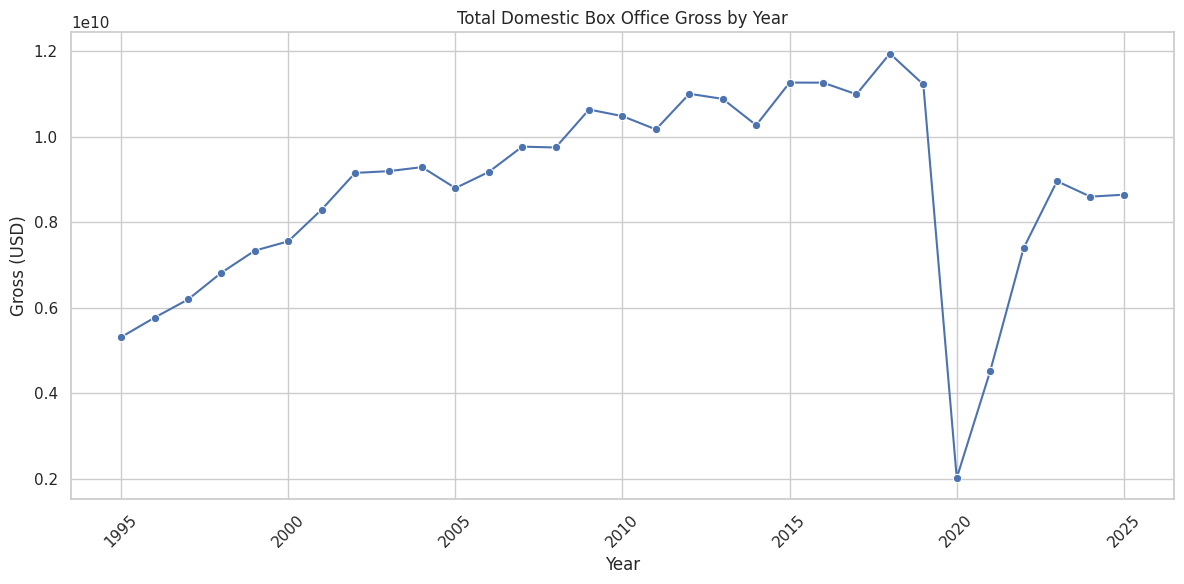

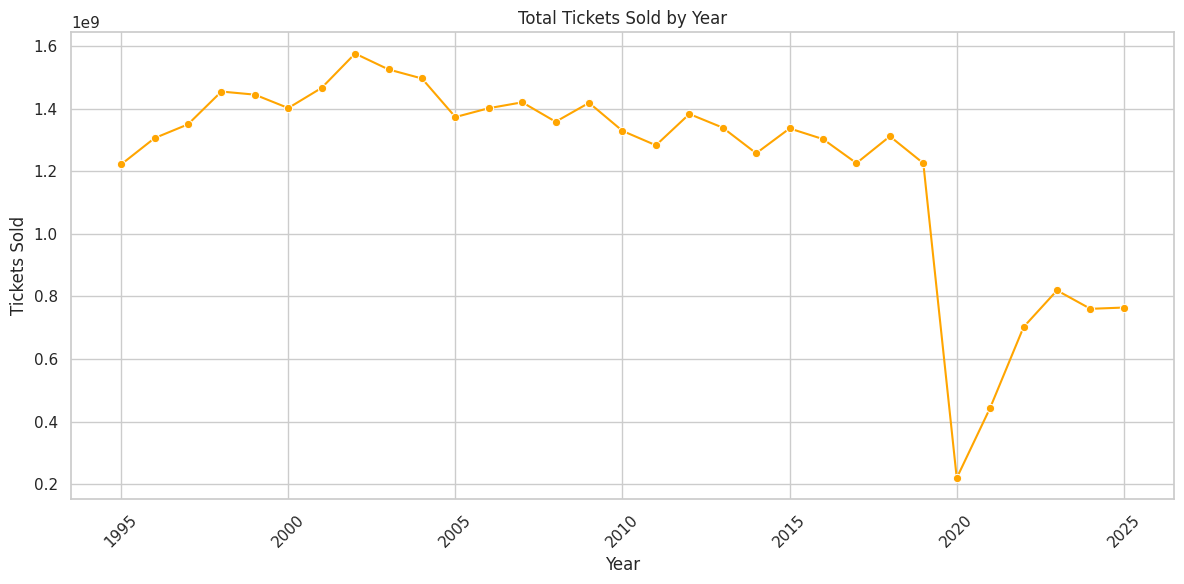

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Box_office_data.csv")

df['Gross'] = df['Gross'].replace('[\$,]', '', regex=True).astype(float)
df['Tickets Sold'] = df['Tickets Sold'].replace('[\$,]', '', regex=True).astype(float)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Gross', marker='o')
plt.title('Total Domestic Box Office Gross by Year')
plt.ylabel('Gross (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Tickets Sold', marker='o', color='orange')
plt.title('Total Tickets Sold by Year')
plt.ylabel('Tickets Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


   Year   Genre          Gross Tickets Sold  Unnamed: 4
0  1995   Drama  1,335,703,611  307,058,238         NaN
1  1995  Comedy  1,038,877,996  307,058,238         NaN
2  1995  Action    960,279,201  220,753,826         NaN
3  1996   Drama  1,259,046,490  284,852,089         NaN
4  1996  Action  1,224,837,394  277,112,515         NaN
Year              int64
Genre            object
Gross            object
Tickets Sold     object
Unnamed: 4      float64
dtype: object
              Year  Unnamed: 4
count    93.000000         0.0
mean   2010.000000         NaN
std       8.992751         NaN
min    1995.000000         NaN
25%    2002.000000         NaN
50%    2010.000000         NaN
75%    2018.000000         NaN
max    2025.000000         NaN
   year   genre         gross  tickets_sold  unnamed:_4
0  1995   Drama  1.335704e+09   307058238.0         NaN
1  1995  Comedy  1.038878e+09   307058238.0         NaN
2  1995  Action  9.602792e+08   220753826.0         NaN
3  1996   Drama  1.259046e+

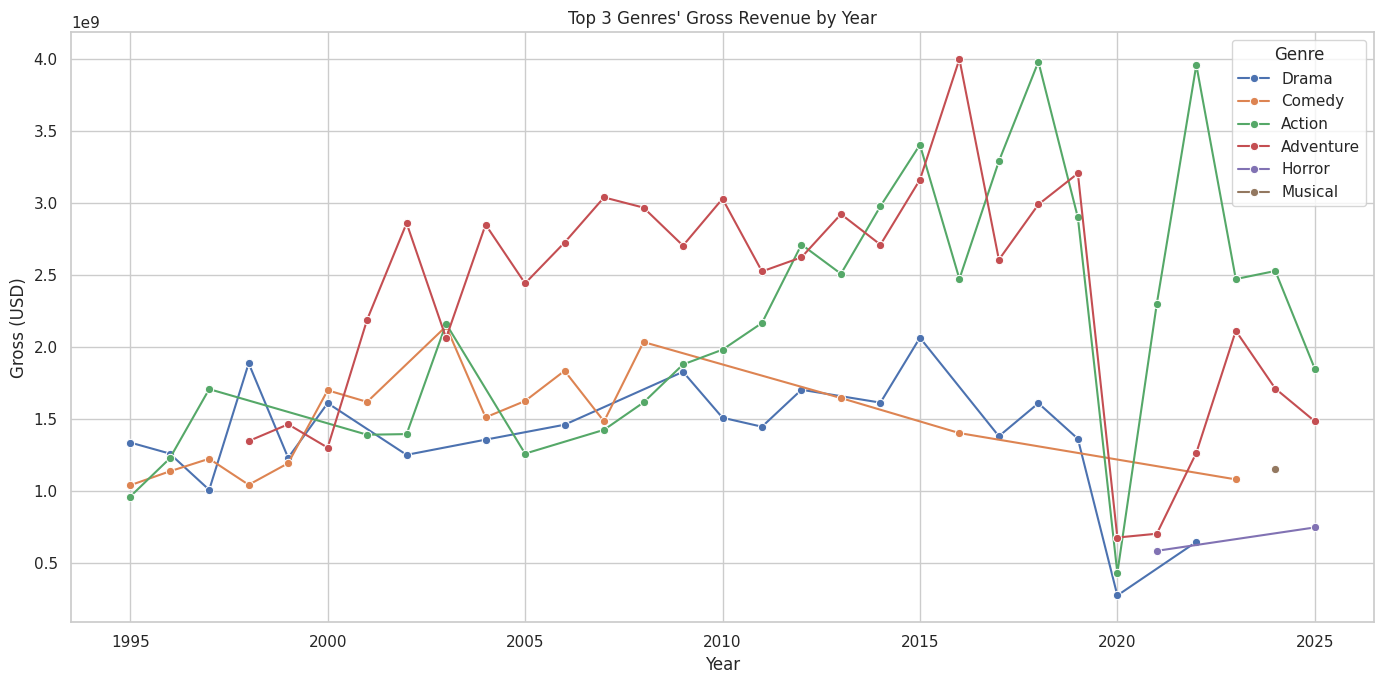

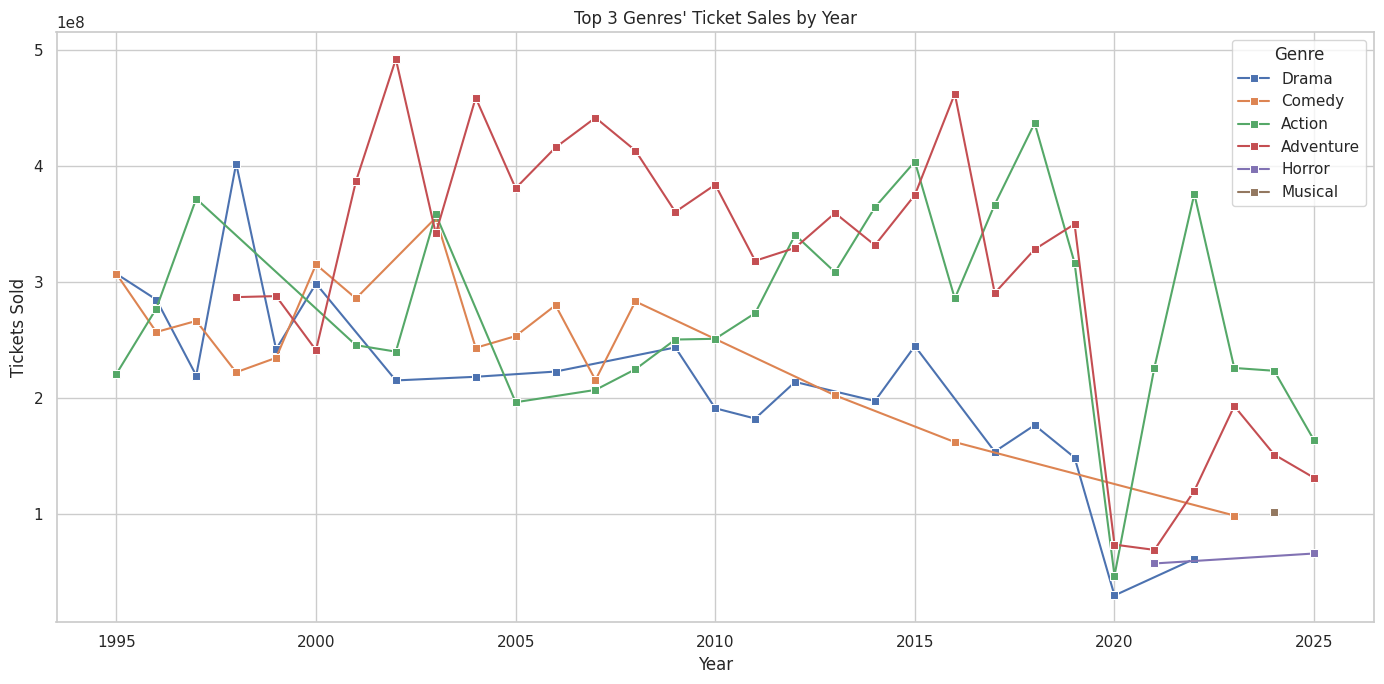

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("genre_stats.csv")

print(df.head())
print(df.dtypes)
print(df.describe())

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

df['gross'] = df['gross'].str.replace(',', '').astype(float)
df['tickets_sold'] = df['tickets_sold'].str.replace(',', '').astype(float)


print(df.head())
print(df.columns)

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='year', y='gross', hue='genre', marker='o')
plt.title("Top 3 Genres' Gross Revenue by Year")
plt.ylabel("Gross (USD)")
plt.xlabel("Year")
plt.legend(title='Genre')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='year', y='tickets_sold', hue='genre', marker='s')
plt.title("Top 3 Genres' Ticket Sales by Year")
plt.ylabel("Tickets Sold")
plt.xlabel("Year")
plt.legend(title='Genre')
plt.grid(True)
plt.tight_layout()
plt.show()


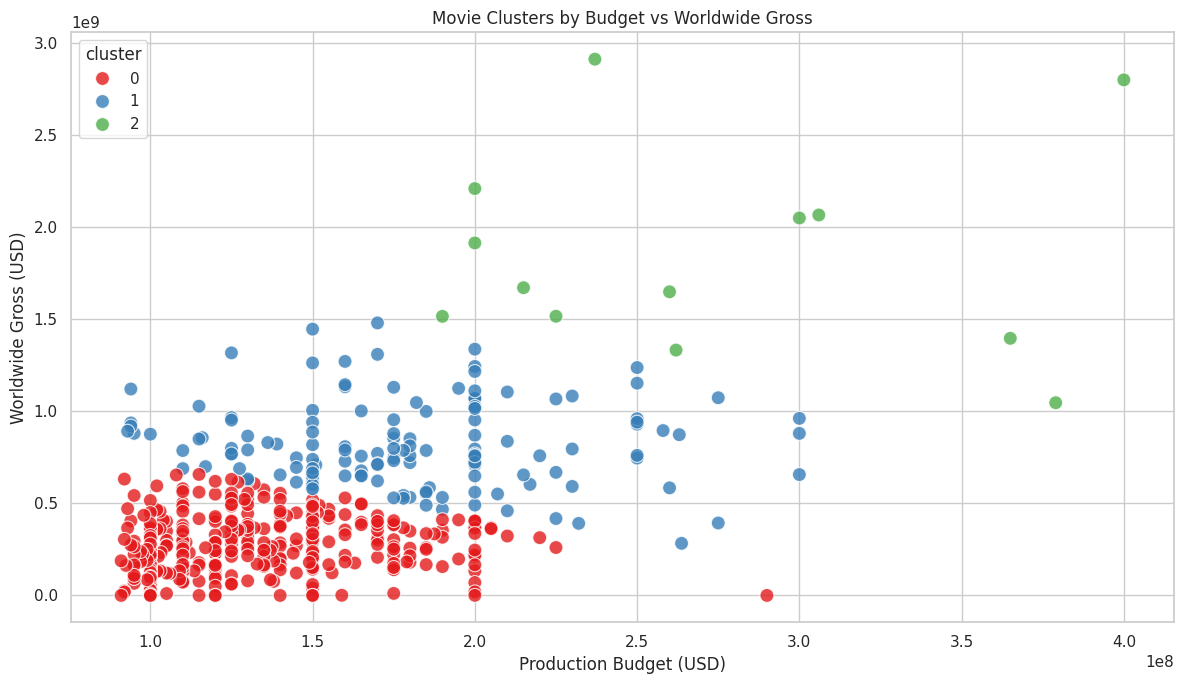

Cluster Summary:
         production_cost  worldwide_gross  tickets_sold
cluster                                                
0           1.324398e+08     2.738043e+08  2.738043e+07
1           1.793664e+08     8.156513e+08  8.156513e+07
2           2.722308e+08     1.850922e+09  1.850922e+08


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("top-500-movies.csv")

df['production_cost'] = pd.to_numeric(df['production_cost'], errors='coerce')
df['worldwide_gross'] = pd.to_numeric(df['worldwide_gross'], errors='coerce')

df = df.dropna(subset=['production_cost', 'worldwide_gross'])

df['tickets_sold'] = df['worldwide_gross'] / 10

features = ['production_cost', 'worldwide_gross', 'tickets_sold']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x='production_cost',
    y='worldwide_gross',
    hue='cluster',
    palette='Set1',
    alpha=0.8,
    s=100
)
plt.title("Movie Clusters by Budget vs Worldwide Gross")
plt.xlabel("Production Budget (USD)")
plt.ylabel("Worldwide Gross (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

cluster_summary = df.groupby('cluster')[features].mean().round(2)
print("Cluster Summary:")
print(cluster_summary)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("top-500-movies.csv")

money_cols = ['production_cost', 'domestic_gross', 'worldwide_gross', 'opening_weekend']
for col in money_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['production_cost', 'domestic_gross'])

df['tickets_sold'] = df['domestic_gross'] / 10

df['concession_revenue'] = df['tickets_sold'] * 2.5

df['estimated_total_revenue'] = df['domestic_gross'] + df['concession_revenue']

df['estimated_profit'] = df['estimated_total_revenue'] - df['production_cost']

df['profit_margin'] = df['estimated_profit'] / df['estimated_total_revenue']

genre_group = df.groupby('genre').agg({
    'concession_revenue': 'sum',
    'estimated_profit': 'sum',
    'profit_margin': 'mean'
}).reset_index()

genre_group = genre_group.sort_values(by='estimated_profit', ascending=False)


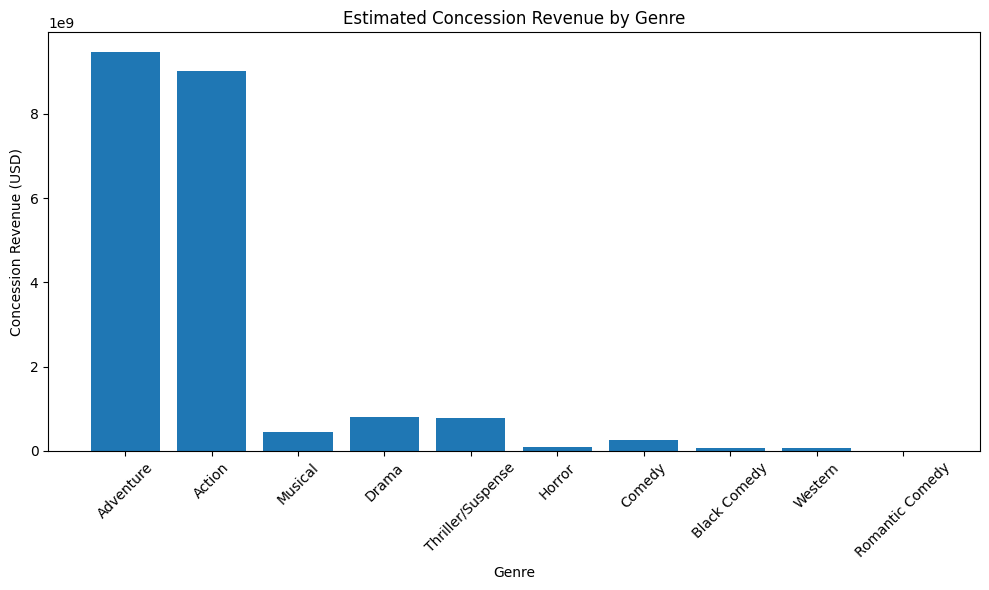

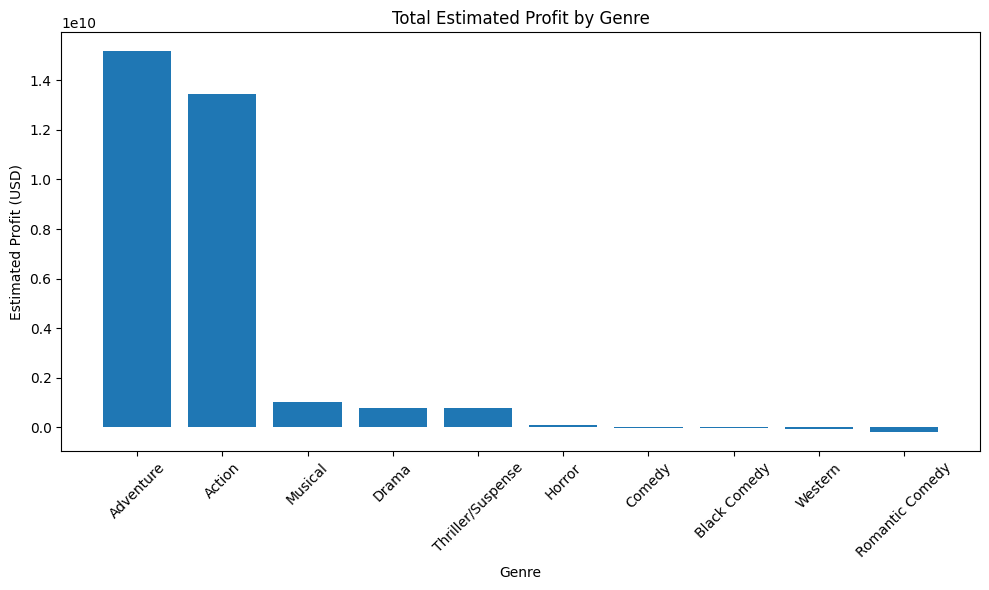

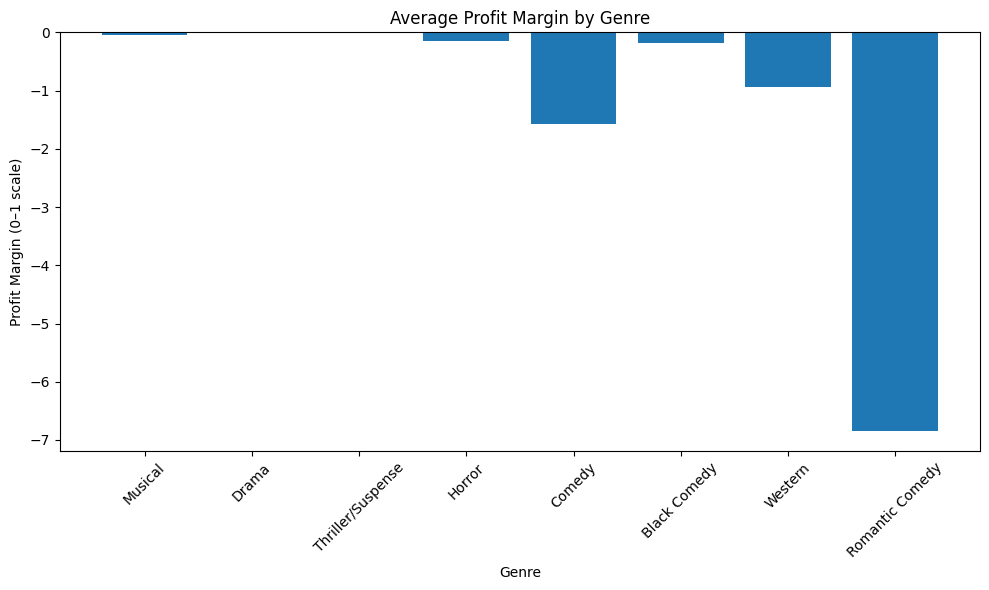

In [ ]:
#Total Concession Revenue by Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_group['genre'], genre_group['concession_revenue'])
plt.title('Estimated Concession Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Concession Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Total Estimated Profit by Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_group['genre'], genre_group['estimated_profit'])
plt.title('Total Estimated Profit by Genre')
plt.xlabel('Genre')
plt.ylabel('Estimated Profit (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Average Profit Margin by Genre
plt.figure(figsize=(10, 6))
plt.bar(genre_group['genre'], genre_group['profit_margin'])
plt.title('Average Profit Margin by Genre')
plt.xlabel('Genre')
plt.ylabel('Profit Margin (0–1 scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
